# AethraDB Filter Query and Aggregation Query Result Analysis
This file contains the result analysis for the first full run of the filter query and aggregation query in the AethraDB engine. Additionally, it contains a comparison against a single-threaded run of the same queries on the same data on DuckDB version 0.8.0 using PyArrow 12.0.0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the Data
We first load the filter query benchmark data from DuckDB.

In [2]:
# Loading the filter query data from DuckDB
duckdb_filter_query_raw = pd.read_csv("./filter_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_filter_query = duckdb_filter_query_raw.copy(deep=True)
duckdb_filter_query["Running-Time"] = duckdb_filter_query["Running-Time"] * 1000
duckdb_filter_query["Running-Time"] = duckdb_filter_query["Running-Time"].round(1)

# Extract the restrictive column
duckdb_filter_query["Restrictive-Column"] = duckdb_filter_query.apply(lambda x: 1 if 'col1_002' in x['Dataset'] else (2 if 'col2_002' in x['Dataset'] else 3), axis=1)

# Drop the dataset column
duckdb_filter_query.drop(columns=['Dataset'], inplace=True)

# Introduce the "Engine" column
duckdb_filter_query["Engine"] = "DuckDB"

duckdb_filter_query.head()

,Running-Time,Restrictive-Column,Engine
0,105.1,1,DuckDB
1,103.7,2,DuckDB
2,104.5,3,DuckDB


Next, we load the aggregation query benchmark data from DuckDB.

In [3]:
# Loading the aggregation query data from DuckDB
duckdb_aggregation_query_raw = pd.read_csv("./aggregation_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_aggregation_query = duckdb_aggregation_query_raw.copy(deep=True)
duckdb_aggregation_query["Running-Time"] = duckdb_aggregation_query_raw["Running-Time"] * 1000
duckdb_aggregation_query["Running-Time"] = duckdb_aggregation_query["Running-Time"].round(1)

# Extract the number of elements in each dataset
duckdb_aggregation_query["Records"] = duckdb_aggregation_query.apply(lambda x: x['Dataset'].split('size_')[1], axis=1)
duckdb_aggregation_query["Records"] = duckdb_aggregation_query["Records"].str.extract('(\d+)').astype(int)

# Extract the number of keys in each dataset
duckdb_aggregation_query["Keys"] = duckdb_aggregation_query.apply(lambda x: x['Dataset'].split('keys_')[1], axis=1)
duckdb_aggregation_query["Keys"] = duckdb_aggregation_query["Keys"].str.extract('(\d+)').astype(int)

# Introduce the "Engine" column
duckdb_aggregation_query["Engine"] = "DuckDB"

# Split the dataset into the skew part and without skew part
duckdb_aggregation_query_skew = duckdb_aggregation_query[duckdb_aggregation_query['Dataset'].str.contains("skew")].copy(deep=True)
duckdb_aggregation_query_no_skew = duckdb_aggregation_query[~duckdb_aggregation_query['Dataset'].str.contains("skew")].copy(deep=True)

# Extract the skew for the skew dataset
duckdb_aggregation_query_skew["Skew"] = duckdb_aggregation_query_skew.apply(lambda x: float(x['Dataset'].split('skew_')[1].split('/')[0]), axis=1)

# Drop the dataset column
duckdb_aggregation_query_skew.drop(columns=['Dataset'], inplace=True)
duckdb_aggregation_query_no_skew.drop(columns=['Dataset'], inplace=True)

duckdb_aggregation_query_skew.head()

,Running-Time,Records,Keys,Engine,Skew
0,955.9,62914560,262144,DuckDB,2.0
4,961.2,62914560,262144,DuckDB,2.2
5,4070.5,62914560,262144,DuckDB,0.6
7,1887.9,62914560,262144,DuckDB,1.2
8,1011.1,62914560,262144,DuckDB,1.8


In [4]:
duckdb_aggregation_query_no_skew.head()

,Running-Time,Records,Keys,Engine
1,496.0,31457280,512,DuckDB
2,464.5,31457280,128,DuckDB
3,471.3,31457280,4,DuckDB
6,798.9,31457280,4096,DuckDB
9,2750.5,31457280,524288,DuckDB


Next, we load the join query data from DuckDB.

In [5]:
# Loading the aggregation query data from DuckDB
duckdb_join_query_raw = pd.read_csv("./join_query_duckdb.csv")

# Convert the running-time to milli-seconds
duckdb_join_query = duckdb_join_query_raw.copy(deep=True)
duckdb_join_query["Running-Time"] = duckdb_join_query["Running-Time"] * 1000
duckdb_join_query["Running-Time"] = duckdb_join_query["Running-Time"].round(1)

# Extract the join selectivity
duckdb_join_query["B_Selectivity"] = duckdb_join_query.apply(lambda x: x['Dataset'].split('/A_B_')[1], axis=1)
duckdb_join_query["C_Selectivity"] = duckdb_join_query.apply(lambda x: x['B_Selectivity'].split('_C_')[1], axis=1)
duckdb_join_query["B_Selectivity"] = duckdb_join_query.apply(lambda x: x['B_Selectivity'].split('_C_')[0], axis=1)

# Introduce the "Engine" column
duckdb_join_query["Engine"] = "DuckDB"

# Introduce the "Dataset_ID" column
duckdb_join_query["Dataset_ID"] = duckdb_join_query.apply(lambda x: x['Dataset'].split('/A_')[1], axis=1)

# Drop the dataset column
duckdb_join_query.drop(columns=['Dataset'], inplace=True)

duckdb_join_query.head()

,Running-Time,B_Selectivity,C_Selectivity,Engine,Dataset_ID
0,669.5,0.8,0.8,DuckDB,B_0.8_C_0.8
1,614.0,0.8,0.2,DuckDB,B_0.8_C_0.2
2,618.2,0.6,0.8,DuckDB,B_0.6_C_0.8
3,520.9,0.4,0.2,DuckDB,B_0.4_C_0.2
4,486.3,0.2,0.6,DuckDB,B_0.2_C_0.6


Finally, we load the data from the AethraDB experiments themselves.

In [6]:
# Load there result from AethraDB
aethra_result_raw = pd.read_csv("aethra-result.csv")

# Take only the average rows and rename the "Score" column to "Running-Time"
aethra_results = aethra_result_raw[~aethra_result_raw['Benchmark'].str.contains('executeFilterQuery:executeFilterQuery')]
aethra_results = aethra_results[~aethra_results['Benchmark'].str.contains('executeQuery:executeQuery')].copy(deep=True)
aethra_results["Running-Time"] = aethra_results["Score"].round(1)

# Introduce the "Engine" column
aethra_results["Engine"] = aethra_results.apply(
    lambda x: "NV-NS" if 'NonVectorisedNonSimd' in x['Benchmark']
    else ("NV-S" if 'NonVectorisedSimd' in x['Benchmark']
          else ("V-NS" if 'VectorisedNonSimd' in x['Benchmark']
                else "V-S")), axis=1)

# Split the result into a filter-query and an aggregation query dataset
aethra_filter_query_result = aethra_results[aethra_results['Benchmark'].str.contains("filter_query")].copy(deep=True)
aethra_aggregation_query_result = aethra_results[aethra_results['Benchmark'].str.contains("aggregation_query")].copy(deep=True)
aethra_join_query_result = aethra_results[aethra_results['Benchmark'].str.contains("join_query")].copy(deep=True)

# For the filter-query dataset, extract the restrictive column
aethra_filter_query_result["Restrictive-Column"] = aethra_filter_query_result.apply(lambda x: 1 if 'col1_002' in x['Param: tableFilePath'] else (2 if 'col2_002' in x['Param: tableFilePath'] else 3), axis=1)

# For the filter-query dataset drop all columns except the "Running-Time" and "Restrictive-Column"
aethra_filter_query_result.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath"], inplace=True)

# For the aggregation query, check if the benchmark verifies the result
aethra_aggregation_query_result["Verifies"] = ~aethra_aggregation_query_result["Benchmark"].str.contains("_No_Verification")

# For the aggregation query, extract the number of elements in each dataset
aethra_aggregation_query_result["Records"] = aethra_aggregation_query_result.apply(lambda x: x['Param: tableFilePath'].split('size_')[1], axis=1)
aethra_aggregation_query_result["Records"] = aethra_aggregation_query_result["Records"].str.extract('(\d+)').astype(int)

# For the aggregation query,  extract the number of keys in each dataset
aethra_aggregation_query_result["Keys"] = aethra_aggregation_query_result.apply(lambda x: x['Param: tableFilePath'].split('keys_')[1], axis=1)
aethra_aggregation_query_result["Keys"] = aethra_aggregation_query_result["Keys"].str.extract('(\d+)').astype(int)

# For the aggregation query, split the dataset into the skew part and without skew part
aethra_aggregation_query_result_skew = aethra_aggregation_query_result[aethra_aggregation_query_result['Param: tableFilePath'].str.contains("skew")].copy(deep=True)
aethra_aggregation_query_result_no_skew = aethra_aggregation_query_result[~aethra_aggregation_query_result['Param: tableFilePath'].str.contains("skew")].copy(deep=True)

# For the aggregation query with skew, extract the skew
aethra_aggregation_query_result_skew["Skew"] = aethra_aggregation_query_result_skew.apply(lambda x: float(x['Param: tableFilePath'].split('skew_')[1].split('/')[0]), axis=1)

# Drop the dataset column of the aggregation query that we do not need
aethra_aggregation_query_result_skew.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath"], inplace=True)
aethra_aggregation_query_result_no_skew.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath"], inplace=True)

# For the join query, extract the selectivity per join column
aethra_join_query_result["B_Selectivity"] = aethra_join_query_result.apply(lambda x: x['Param: tableFilePath'].split('/A_B_')[1], axis=1)
aethra_join_query_result["C_Selectivity"] = aethra_join_query_result.apply(lambda x: x['B_Selectivity'].split('_C_')[1], axis=1)
aethra_join_query_result["B_Selectivity"] = aethra_join_query_result.apply(lambda x: x['B_Selectivity'].split('_C_')[0], axis=1)

# For the join query, introduce the Dataset_ID column
aethra_join_query_result["Dataset_ID"] = aethra_join_query_result.apply(lambda x: x['Param: tableFilePath'].split('/A_')[1], axis=1)

# For the join query, drop the columns that we do not need
aethra_join_query_result.drop(columns=["Benchmark", "Mode", "Threads", "Samples", "Score", "Score Error (99.9%)", "Unit", "Param: tableFilePath"], inplace=True)

In [7]:
aethra_filter_query_result.head()

,Running-Time,Engine,Restrictive-Column
2304,46.2,NV-NS,1
2313,52.4,NV-NS,2
2322,46.9,NV-NS,3
2331,39.4,NV-S,1
2340,39.4,NV-S,2


In [8]:
aethra_aggregation_query_result_skew.head()

,Running-Time,Engine,Verifies,Records,Keys,Skew
180,17916.7,NV-NS,True,62914560,262144,0.2
189,16345.0,NV-NS,True,62914560,262144,0.4
198,13764.7,NV-NS,True,62914560,262144,0.6
207,9891.8,NV-NS,True,62914560,262144,0.8
216,5549.2,NV-NS,True,62914560,262144,1.0


In [9]:
aethra_aggregation_query_result_no_skew.head()

,Running-Time,Engine,Verifies,Records,Keys
0,436.2,NV-NS,True,31457280,1
9,437.3,NV-NS,True,31457280,2
18,606.2,NV-NS,True,31457280,4
27,527.1,NV-NS,True,31457280,8
36,610.8,NV-NS,True,31457280,16


In [10]:
aethra_join_query_result.head()

,Running-Time,Engine,B_Selectivity,C_Selectivity,Dataset_ID
2412,1290.1,NV-NS,0.2,0.2,B_0.2_C_0.2
2421,1317.7,NV-NS,0.2,0.4,B_0.2_C_0.4
2430,1343.0,NV-NS,0.2,0.6,B_0.2_C_0.6
2439,1364.5,NV-NS,0.2,0.8,B_0.2_C_0.8
2448,1746.4,NV-NS,0.4,0.2,B_0.4_C_0.2


## Analysing the Filter Query Performance
We create a plot of the running-time per engine and per restrictive column for the filter query.

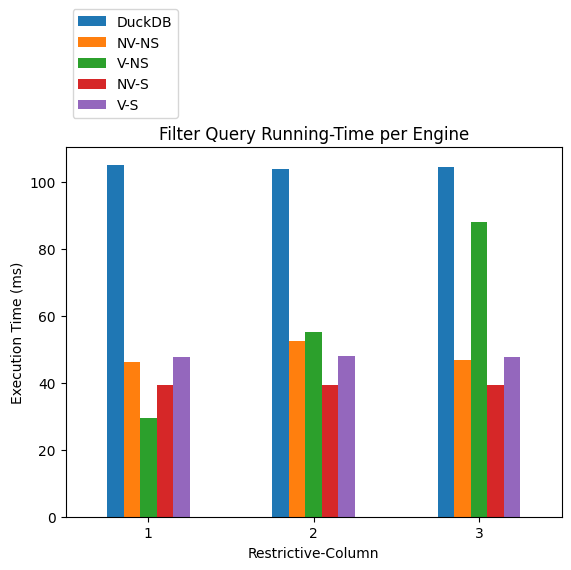

In [11]:
index_column = "Restrictive-Column"

duckdb_data = duckdb_filter_query.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_filter_query_result[aethra_filter_query_result["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0)
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Filter Query Running-Time per Engine")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## Analysing the Aggregation Query Performance (Influence of #Keys, no Skew)
Below we analyse the performance of the Aggregation Query for each engine, where we focus on the influence of the amount of unique keys in the aggregation. We present results both for the query implementations that check the final result, and those that do not check the result. 

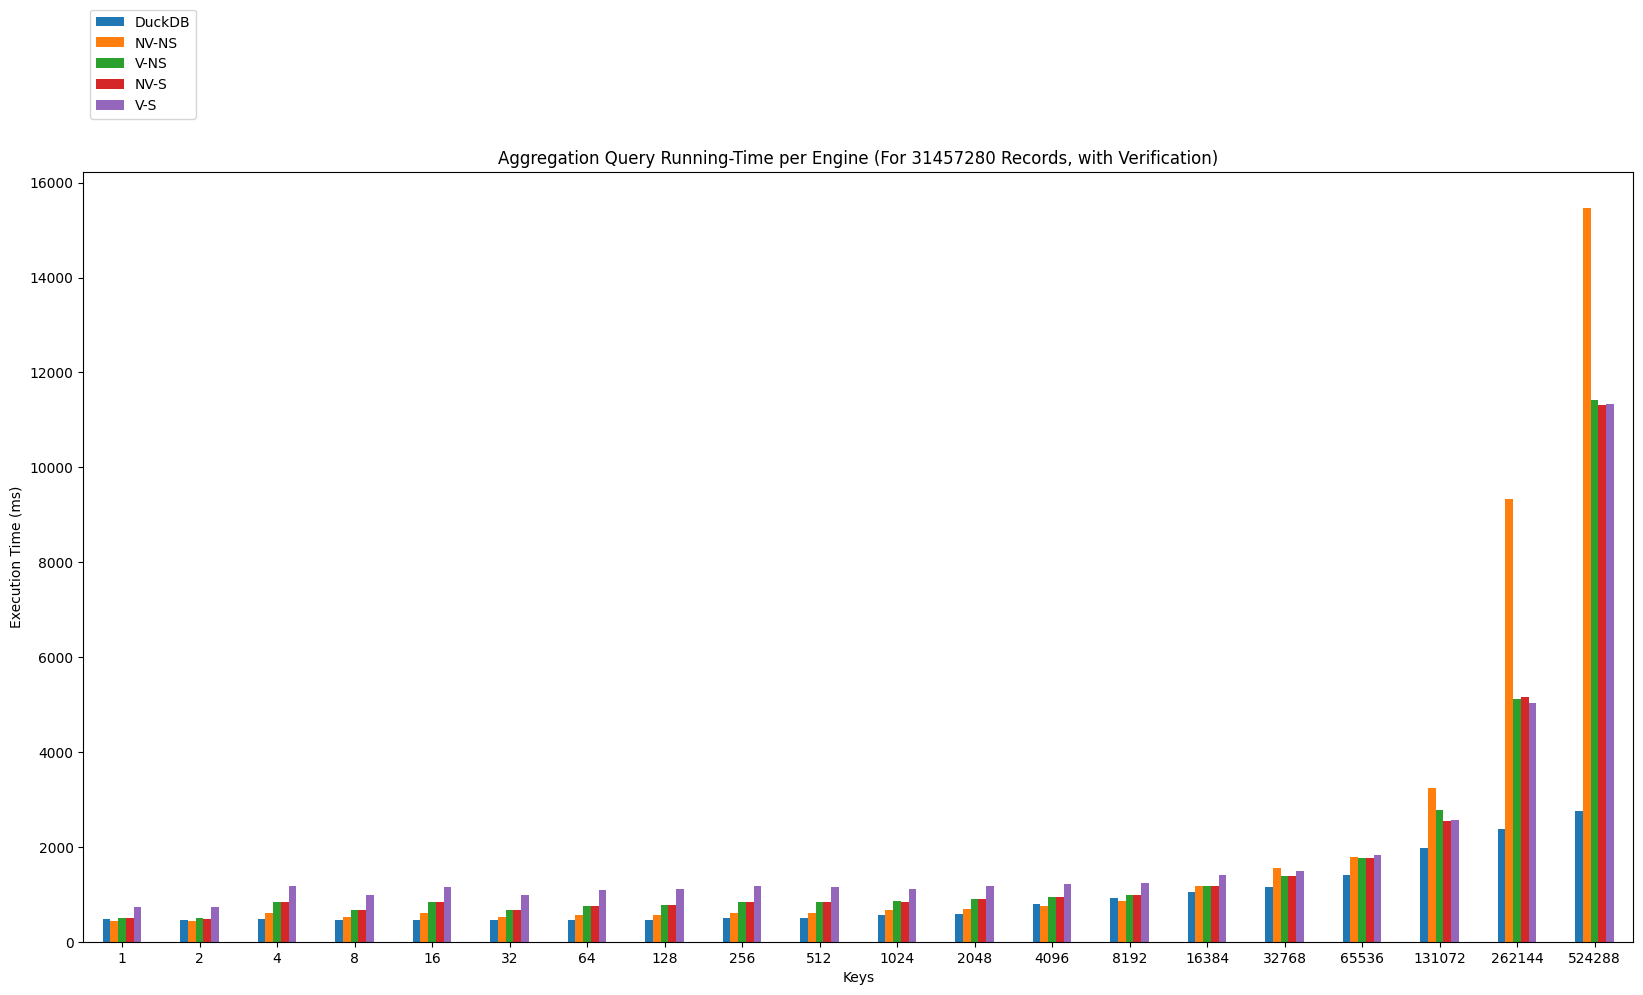

In [12]:
index_column = "Keys"

duckdb_data = duckdb_aggregation_query_no_skew.sort_values(index_column)
index = duckdb_data[index_column]

aethra_aggregation_query_result_no_skew_with_verify = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Verifies"]]

aethra_nv_ns_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 31457280 Records, with Verification)")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

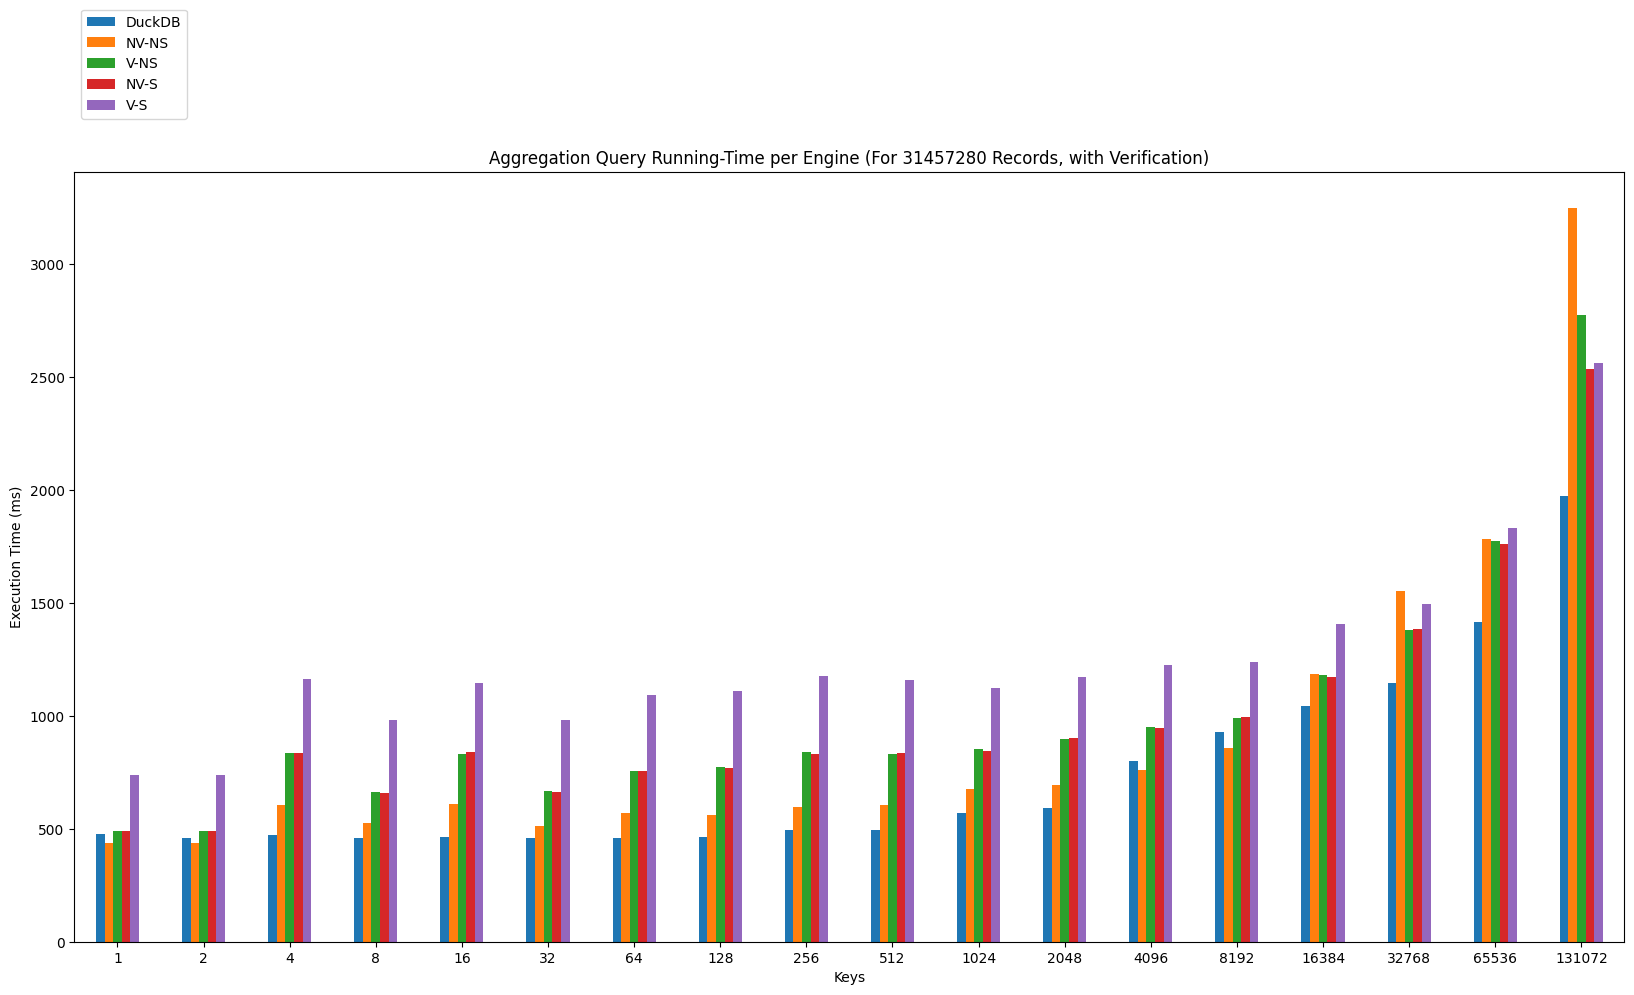

In [20]:
index_column = "Keys"

duckdb_data = duckdb_aggregation_query_no_skew[duckdb_aggregation_query_no_skew[index_column] <= 131072].sort_values(index_column)
index = duckdb_data[index_column]

aethra_aggregation_query_result_no_skew_with_verify = aethra_aggregation_query_result_no_skew[aethra_aggregation_query_result_no_skew["Verifies"]]
aethra_aggregation_query_result_no_skew_with_verify = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify[index_column] <= 131072]

aethra_nv_ns_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_no_skew_with_verify[aethra_aggregation_query_result_no_skew_with_verify["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 31457280 Records, with Verification)")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

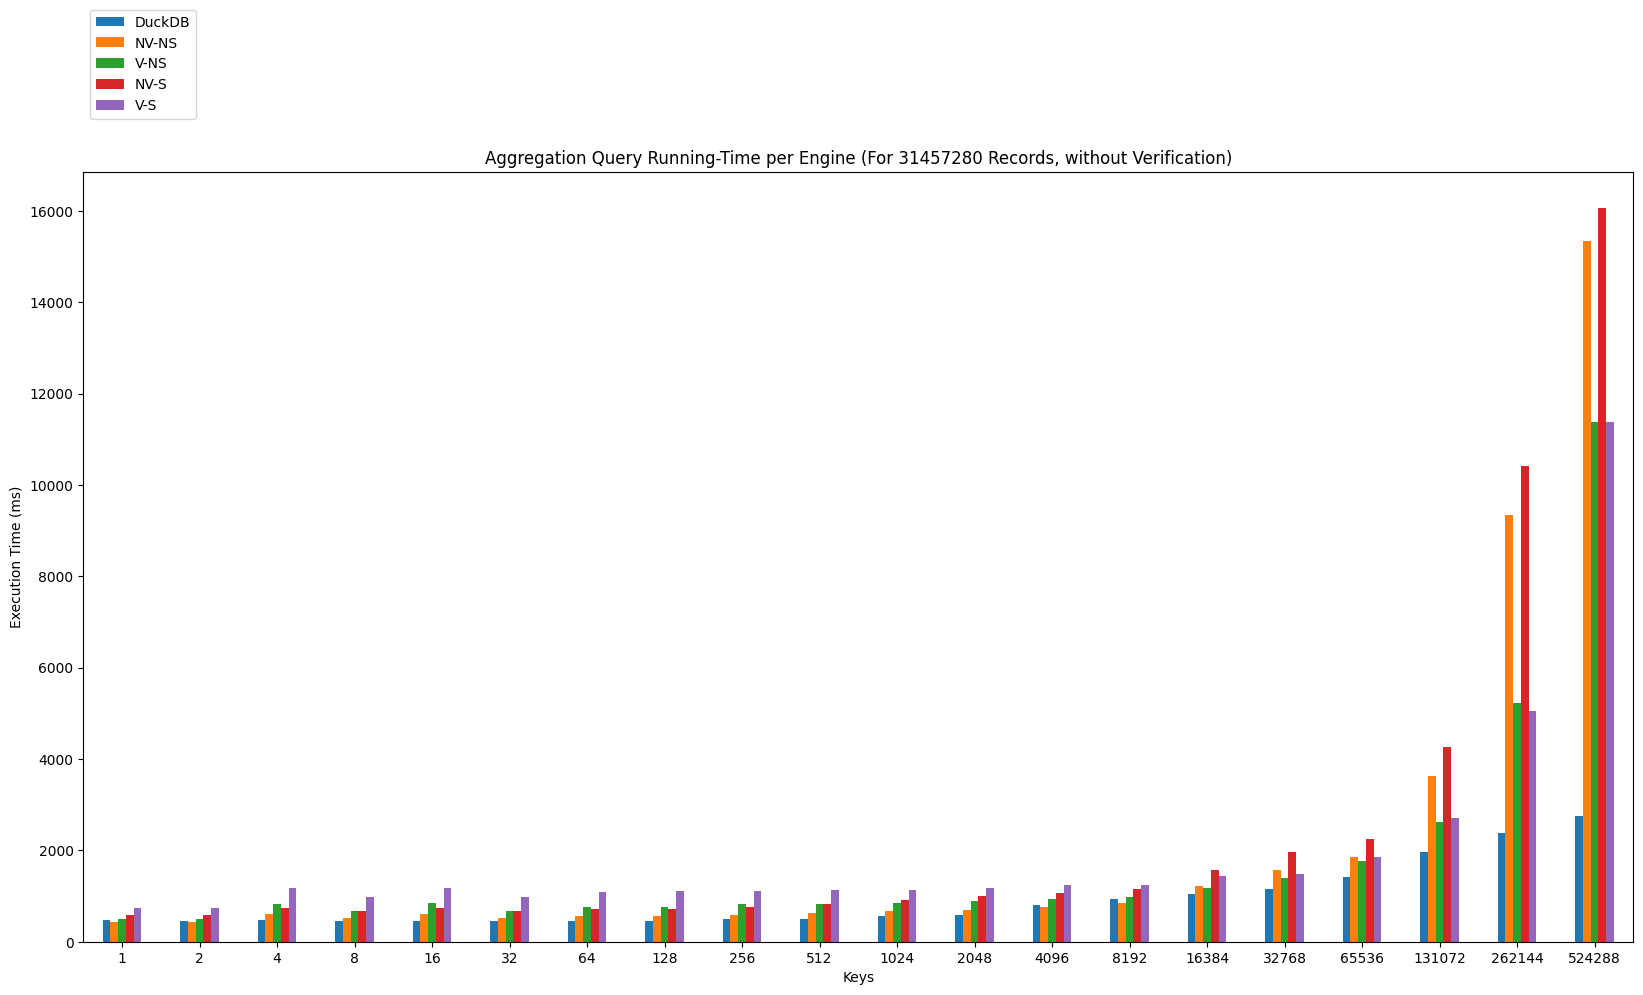

In [13]:
index_column = "Keys"

duckdb_data = duckdb_aggregation_query_no_skew.sort_values(index_column)
index = duckdb_data[index_column]

aethra_aggregation_query_result_no_skew_without_verify = aethra_aggregation_query_result_no_skew[~aethra_aggregation_query_result_no_skew["Verifies"]]

aethra_nv_ns_data = aethra_aggregation_query_result_no_skew_without_verify[aethra_aggregation_query_result_no_skew_without_verify["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_no_skew_without_verify[aethra_aggregation_query_result_no_skew_without_verify["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_no_skew_without_verify[aethra_aggregation_query_result_no_skew_without_verify["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_no_skew_without_verify[aethra_aggregation_query_result_no_skew_without_verify["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 31457280 Records, without Verification)")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## Analysing the Aggregation Query Performance (Influence of Key Skew)
Below we analyse the performance of the Aggregation Query for each engine, where we focus on the influence of the skew of values against keys in the aggregation. We present results both for the query implementations that check the final result, and those that do not check the result.

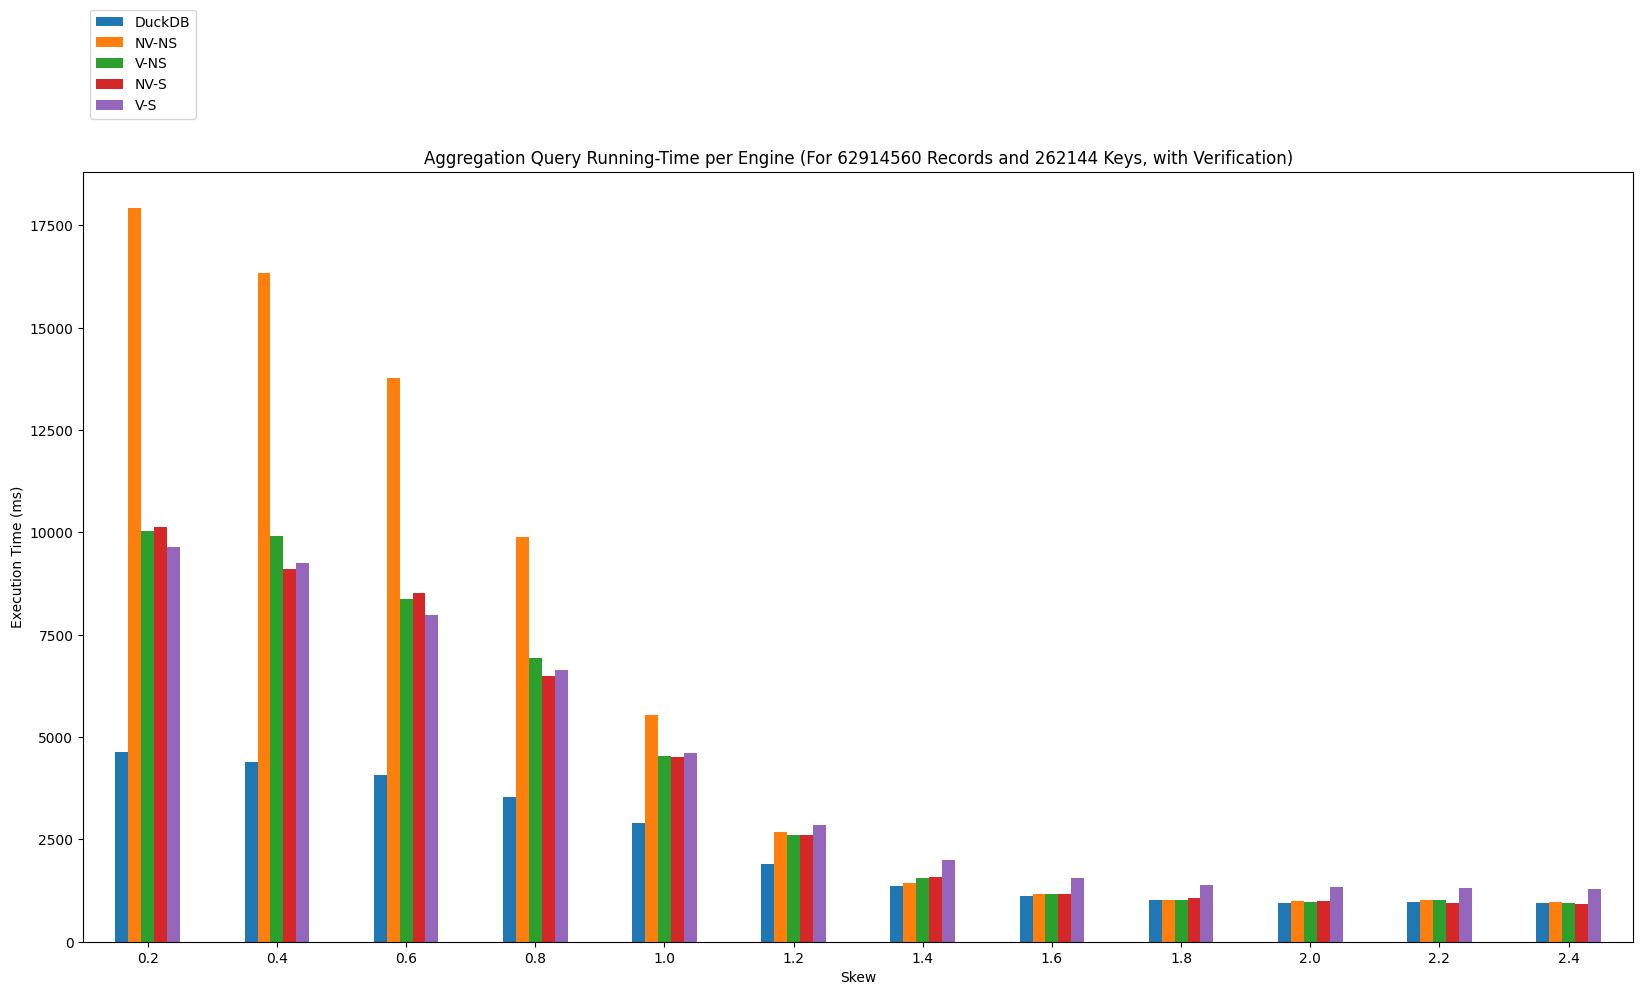

In [14]:
index_column = "Skew"

duckdb_data = duckdb_aggregation_query_skew.sort_values(index_column)
index = duckdb_data[index_column]

aethra_aggregation_query_result_skew_with_verify = aethra_aggregation_query_result_skew[aethra_aggregation_query_result_skew["Verifies"]]

aethra_nv_ns_data = aethra_aggregation_query_result_skew_with_verify[aethra_aggregation_query_result_skew_with_verify["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_skew_with_verify[aethra_aggregation_query_result_skew_with_verify["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_skew_with_verify[aethra_aggregation_query_result_skew_with_verify["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_skew_with_verify[aethra_aggregation_query_result_skew_with_verify["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 62914560 Records and 262144 Keys, with Verification)")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

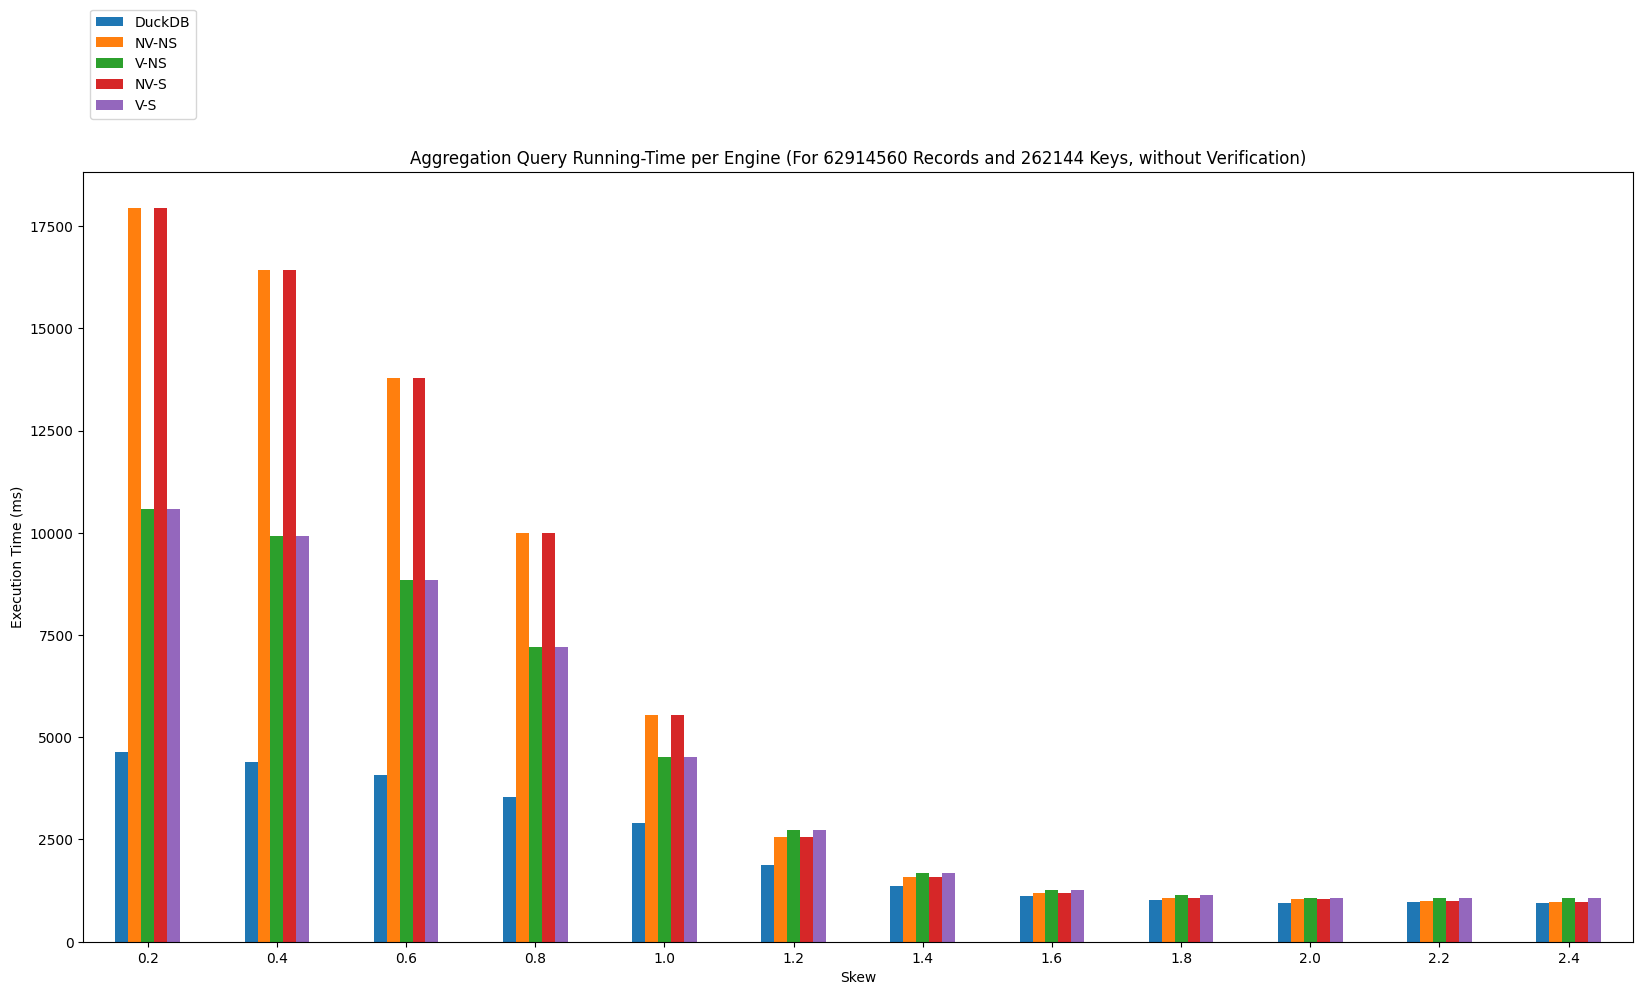

In [15]:
index_column = "Skew"

duckdb_data = duckdb_aggregation_query_skew.sort_values(index_column)
index = duckdb_data[index_column]

aethra_aggregation_query_result_skew_without_verify = aethra_aggregation_query_result_skew[~aethra_aggregation_query_result_skew["Verifies"]]

aethra_nv_ns_data = aethra_aggregation_query_result_skew_without_verify[aethra_aggregation_query_result_skew_without_verify["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_aggregation_query_result_skew_without_verify[aethra_aggregation_query_result_skew_without_verify["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_aggregation_query_result_skew_without_verify[aethra_aggregation_query_result_skew_without_verify["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_aggregation_query_result_skew_without_verify[aethra_aggregation_query_result_skew_without_verify["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-S': aethra_v_ns_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Aggregation Query Running-Time per Engine (For 62914560 Records and 262144 Keys, without Verification)")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

## Analysing the Join Query Performance
Below we analyse the performance of the Join Query for each engine. The different datasets indicate the different join selectivity levels.

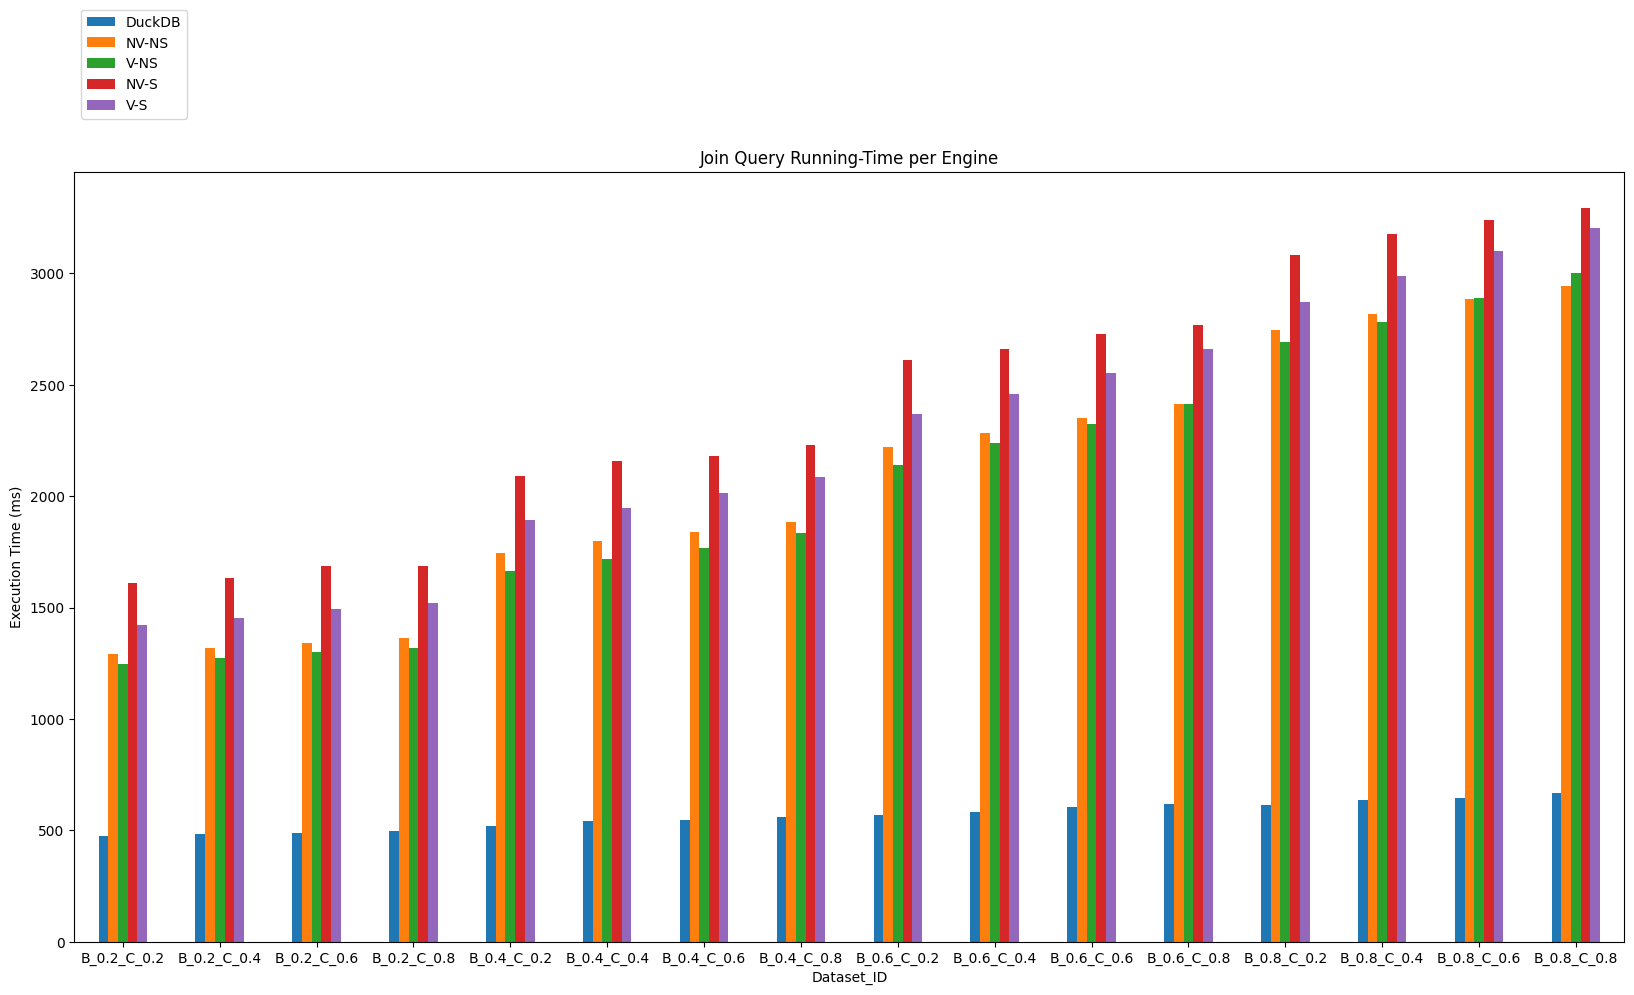

In [16]:
index_column = "Dataset_ID"

duckdb_data = duckdb_join_query.sort_values(index_column)
index = duckdb_data[index_column]

aethra_nv_ns_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "NV-NS"].sort_values(index_column)
aethra_nv_s_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "NV-S"].sort_values(index_column)
aethra_v_ns_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "V-NS"].sort_values(index_column)
aethra_v_s_data = aethra_join_query_result[aethra_join_query_result["Engine"] == "V-S"].sort_values(index_column)

df = pd.DataFrame({
    'DuckDB': duckdb_data["Running-Time"].tolist(),
    'NV-NS': aethra_nv_ns_data["Running-Time"].tolist(),
    'V-NS': aethra_v_ns_data["Running-Time"].tolist(),
    'NV-S': aethra_nv_s_data["Running-Time"].tolist(),
    'V-S': aethra_v_s_data["Running-Time"].tolist(),
}, index = index)

ax = df.plot.bar(rot=0,figsize=(20,10))
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Join Query Running-Time per Engine")
ax.legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))